# Analyseren van COVID-19 Papers

In deze uitdaging gaan we verder met het onderwerp van de COVID-pandemie en richten we ons op het verwerken van wetenschappelijke artikelen over dit onderwerp. Er is een [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) met meer dan 7000 (op het moment van schrijven) artikelen over COVID, beschikbaar met metadata en samenvattingen (en voor ongeveer de helft is ook de volledige tekst beschikbaar).

Een volledig voorbeeld van het analyseren van deze dataset met behulp van de cognitieve service [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) wordt beschreven [in deze blogpost](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). We zullen een vereenvoudigde versie van deze analyse bespreken.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Het verkrijgen van de data

Eerst moeten we de metadata ophalen voor CORD-artikelen waarmee we gaan werken.

**NOTE**: We bieden geen kopie van de dataset aan als onderdeel van deze repository. Mogelijk moet je eerst het bestand [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) downloaden van [deze dataset op Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Registratie bij Kaggle kan vereist zijn. Je kunt de dataset ook zonder registratie downloaden [via deze link](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), maar deze zal naast het metadata-bestand ook alle volledige teksten bevatten.

We zullen proberen de data rechtstreeks van een online bron te verkrijgen, maar als dat niet lukt, moet je de data downloaden zoals hierboven beschreven. Het is ook verstandig om de data te downloaden als je van plan bent er verder mee te experimenteren, om wachttijd te besparen.

> **NOTE** dat de dataset behoorlijk groot is, ongeveer 1 Gb, en dat de volgende regel code veel tijd kan kosten om uit te voeren! (~5 minuten)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

We zullen nu de kolom met publicatiedata converteren naar `datetime`, en de histogram plotten om het bereik van publicatiedata te bekijken.


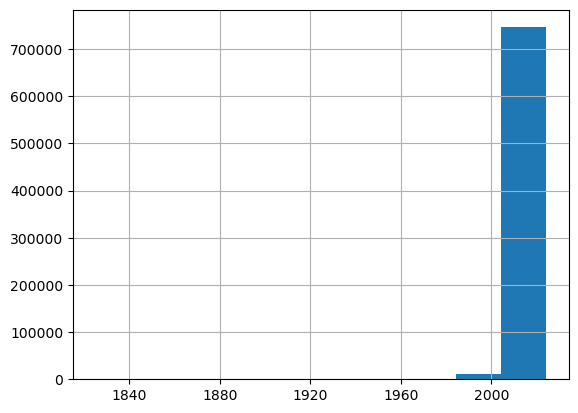

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Gestructureerde Gegevensextractie

Laten we eens kijken wat voor soort informatie we eenvoudig uit samenvattingen kunnen halen. Een aspect dat interessant kan zijn, is om te zien welke behandelstrategieën er bestaan en hoe deze in de loop van de tijd zijn geëvolueerd. Om te beginnen kunnen we handmatig een lijst samenstellen van mogelijke medicijnen die worden gebruikt om COVID te behandelen, evenals een lijst met diagnoses. Vervolgens doorlopen we deze lijsten en zoeken we naar overeenkomende termen in de samenvattingen van artikelen.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


We hebben een aantal kolommen toegevoegd aan onze dataframe die het aantal keren bevatten dat een bepaalde medicijn/diagnose voorkomt in de samenvatting.

> **Let op** dat we een spatie toevoegen aan het begin van het woord wanneer we zoeken naar een substring. Als we dat niet doen, kunnen we verkeerde resultaten krijgen, omdat *chloroquine* ook gevonden zou worden binnen de substring *hydroxychloroquine*. Daarnaast forceren we de conversie van de kolom abstracts naar `str` om een fout te voorkomen - probeer `str` te verwijderen en kijk wat er gebeurt.

Om het werken met data eenvoudiger te maken, kunnen we het sub-frame met alleen medicijntellingen extraheren en het totale aantal voorkomens berekenen. Dit geeft ons het meest populaire medicijn:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

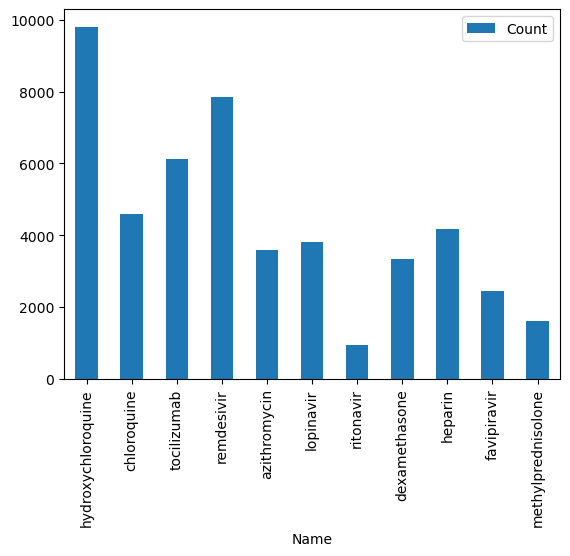

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Op zoek naar trends in behandelingsstrategie

In het bovenstaande voorbeeld hebben we alle waarden `sum` opgeteld, maar we kunnen dit ook maandelijks doen:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

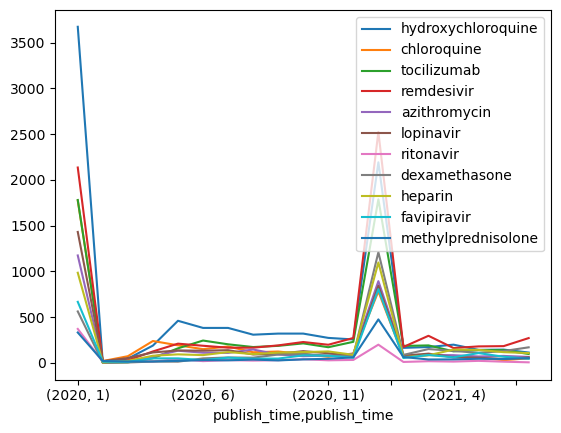

In [152]:
dfmt.plot()
plt.show()

Een interessante observatie is dat we enorme pieken hebben op twee locaties: januari 2020 en januari 2021. Dit wordt veroorzaakt door het feit dat sommige artikelen geen duidelijk gespecificeerde publicatiedatum hebben, en ze worden aangegeven als januari van het betreffende jaar.

Om meer inzicht te krijgen in de gegevens, laten we slechts een paar medicijnen visualiseren. We zullen ook de gegevens voor januari "wissen" en deze invullen met een gemiddelde waarde, zodat we een mooier diagram krijgen:


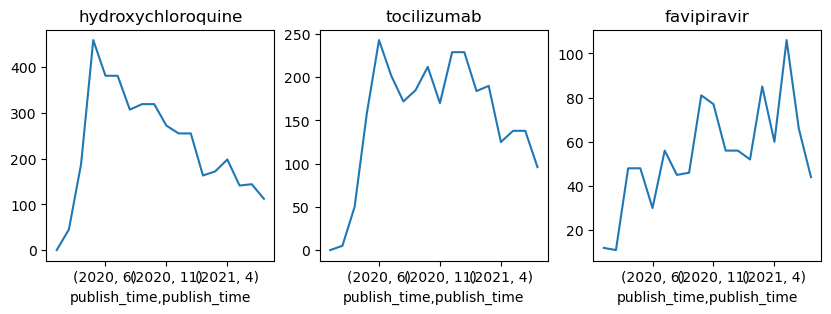

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

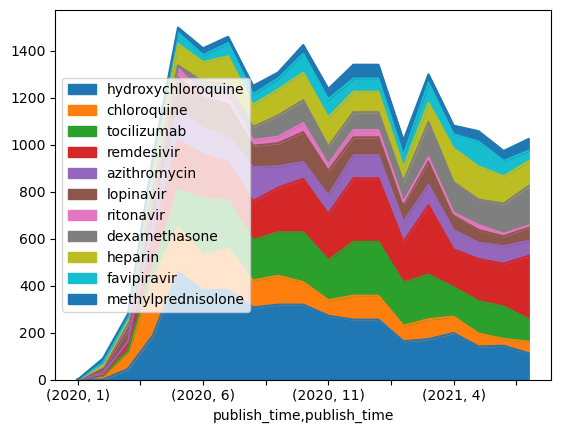

In [154]:
dfmt.plot.area()
plt.show()

Zelfs verder kunnen we de relatieve populariteit in procenten berekenen:


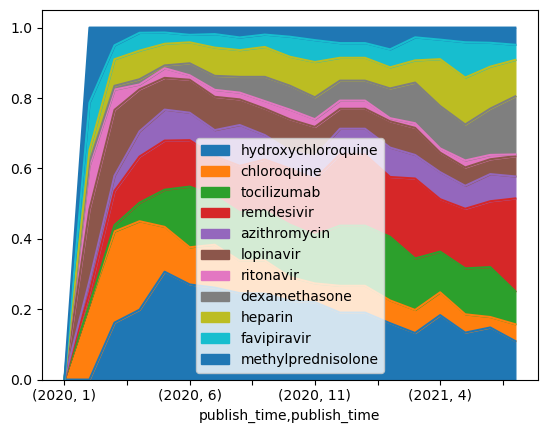

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Correspondentie tussen medicijnen en diagnoses

Een van de meest interessante relaties die we kunnen onderzoeken, is hoe verschillende diagnoses worden behandeld met verschillende medicijnen. Om dit te visualiseren, moeten we een **co-occurratiefrequentiekaart** berekenen, die laat zien hoe vaak twee termen in hetzelfde artikel worden genoemd.

Zo'n kaart is in feite een 2D-matrix, die het beste kan worden weergegeven als een **numpy-array**. We zullen deze kaart berekenen door alle samenvattingen door te nemen en de entiteiten te markeren die daar voorkomen:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Een van de manieren om deze matrix te visualiseren is door een **heatmap** te tekenen:


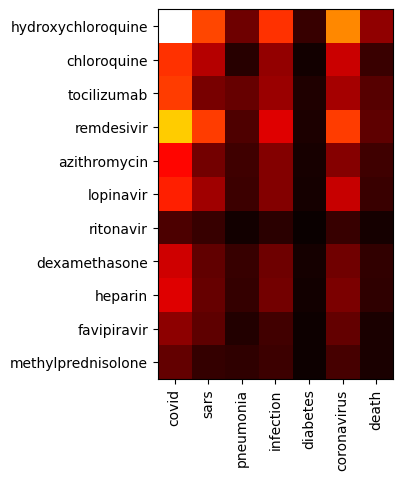

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Echter, een nog betere visualisatie kan worden gemaakt met behulp van een zogenaamd **Sankey**-diagram! `matplotlib` heeft geen ingebouwde ondersteuning voor dit type diagram, dus we moeten [Plotly](https://plotly.com/python/) gebruiken zoals beschreven [in deze tutorial](https://plotly.com/python/sankey-diagram/).

Om een Sankey-diagram met Plotly te maken, moeten we de volgende lijsten opstellen:
* Lijst `all_nodes` met alle knooppunten in de grafiek, die zowel medicatie als diagnoses omvat
* Lijst van bron- en doelindices - deze lijsten laten zien welke knooppunten naar links gaan en welke naar het rechterdeel van het diagram
* Lijst van alle verbindingen, waarbij elke verbinding bestaat uit:
   - Bronindex in de `all_nodes`-array
   - Doelindex
   - Waarde die de sterkte van de verbinding aangeeft. Dit is precies de waarde uit onze co-occurrencematrix.
   - Optioneel de kleur van de verbinding. We zullen een optie toevoegen om bepaalde termen te markeren voor meer duidelijkheid

Generieke code om een Sankey-diagram te tekenen is gestructureerd als een aparte `sankey`-functie, die twee lijsten (bron- en doelcategorieën) en een co-occurrencematrix accepteert. Het stelt ons ook in staat om een drempelwaarde op te geven en alle verbindingen die zwakker zijn dan die drempelwaarde weg te laten - dit maakt het diagram iets minder complex.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Conclusie

Je hebt gezien dat we vrij eenvoudige methoden kunnen gebruiken om informatie te halen uit ongestructureerde gegevensbronnen, zoals tekst. In dit voorbeeld hebben we een bestaande lijst met medicijnen gebruikt, maar het zou veel krachtiger zijn om technieken voor natuurlijke taalverwerking (NLP) te gebruiken om entiteiten uit tekst te extraheren. In [deze blogpost](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) beschrijven we hoe je cloudservices kunt gebruiken voor entiteitsextractie. Een andere optie is het gebruik van Python NLP-bibliotheken zoals [NLTK](https://www.nltk.org/) - een aanpak voor het extraheren van informatie uit tekst met behulp van NLTK wordt [hier](https://www.nltk.org/book/ch07.html) beschreven.


## Uitdaging

Blijf onderzoek doen naar de COVID-papergegevens langs de volgende lijnen:

1. Bouw een co-occurrenciematrix van verschillende medicijnen en kijk welke medicijnen vaak samen voorkomen (d.w.z. genoemd in één samenvatting). Je kunt de code aanpassen voor het bouwen van een co-occurrenciematrix voor medicijnen en diagnoses.
1. Visualiseer deze matrix met behulp van een heatmap.
1. Als extra uitdaging kun je proberen de co-occurrence van medicijnen te visualiseren met behulp van een [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram). [Deze bibliotheek](https://pypi.org/project/chord/) kan je helpen bij het tekenen van een chord diagram.
1. Als nog een extra uitdaging, probeer de doseringen van verschillende medicijnen te extraheren (zoals **400mg** in *neem dagelijks 400mg chloroquine*) met behulp van reguliere expressies, en bouw een dataframe dat verschillende doseringen voor verschillende medicijnen toont. **Let op**: houd rekening met numerieke waarden die zich in de nabije tekstuele omgeving van de medicijnnaam bevinden.



---

**Disclaimer**:  
Dit document is vertaald met behulp van de AI-vertalingsservice [Co-op Translator](https://github.com/Azure/co-op-translator). Hoewel we streven naar nauwkeurigheid, dient u zich ervan bewust te zijn dat geautomatiseerde vertalingen fouten of onnauwkeurigheden kunnen bevatten. Het originele document in de oorspronkelijke taal moet worden beschouwd als de gezaghebbende bron. Voor kritieke informatie wordt professionele menselijke vertaling aanbevolen. Wij zijn niet aansprakelijk voor misverstanden of verkeerde interpretaties die voortvloeien uit het gebruik van deze vertaling.
